In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# Ensure results are reproducable
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [61]:
def mnist_load_data(path='mnist.npz'):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)
        

(X_train, y_train), (X_test, y_test) = mnist_load_data(path='../input/mnist.npz')

In [62]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

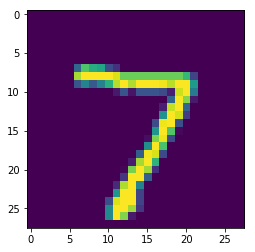

In [63]:
plt.imshow(X_test[0])

In [64]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

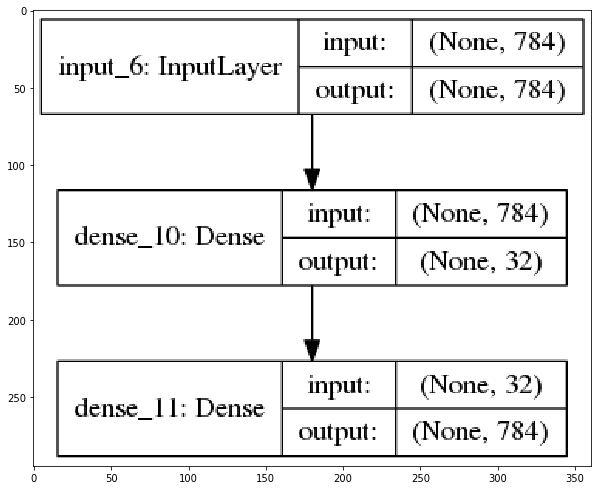

In [65]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True)
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('model.png'))

In [66]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [67]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [68]:
X_train_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_flat = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [69]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [70]:
autoencoder.fit(X_train_flat, X_train_flat,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_flat, X_test_flat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.3558 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2642 - val_loss: 0.2538
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2441 - val_loss: 0.2320
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2239 - val_loss: 0.2134
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2075 - val_loss: 0.1992
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1955 - val_loss: 0.1893
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1868 - val_loss: 0.1819
Epoch 8/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1798 - val_loss: 0.1754
Epoch 9/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1739 - val_loss: 0.1701
Epoch

In [71]:
original = np.expand_dims(X_test_flat[0],0)
seven = autoencoder.predict(original)

In [72]:
seven = seven.reshape(1,28,28)

In [73]:
original = original.reshape(1,28,28)

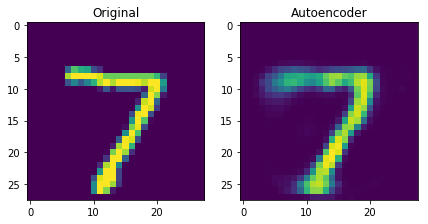

In [74]:
fig = plt.figure(figsize=(7, 10))
a=fig.add_subplot(1,2,1)
a.set_title('Original')
imgplot = plt.imshow(original[0,:,:])

b=fig.add_subplot(1,2,2)
b.set_title('Autoencoder')
imgplot = plt.imshow(seven[0,:,:])

# VAE

In [75]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

In [76]:
batch_size = 100
original_dim = 784
latent_dim = 32
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [77]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [78]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [79]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling)([z_mean, z_log_var])

In [80]:
# we instantiate these layers separately so as to reuse them later
h_decoded = Dense(intermediate_dim, activation='relu')(z)

x_decoded = Dense(original_dim, activation='sigmoid')(h_decoded)

In [81]:
# instantiate VAE model
vae = Model(x, x_decoded)

In [82]:
# Compute VAE loss
reconstruction_loss = original_dim * metrics.binary_crossentropy(x, x_decoded)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [83]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          200960      input_8[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 32)           8224        dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           8224        dense_12[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

In [84]:
vae.fit(X_train_flat,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_flat, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 64us/step - loss: 159.8752 - val_loss: 130.9053
Epoch 2/50
60000/60000 [==============================] - 4s 70us/step - loss: 126.9431 - val_loss: 120.5206
Epoch 3/50
60000/60000 [==============================] - 5s 80us/step - loss: 119.3553 - val_loss: 116.8157
Epoch 4/50
60000/60000 [==============================] - 4s 73us/step - loss: 115.5697 - val_loss: 113.6902
Epoch 5/50
60000/60000 [==============================] - 4s 68us/step - loss: 113.2996 - val_loss: 111.5416
Epoch 6/50
60000/60000 [==============================] - 4s 66us/step - loss: 111.8469 - val_loss: 110.2709
Epoch 7/50
60000/60000 [==============================] - 4s 63us/step - loss: 110.7690 - val_loss: 110.2429
Epoch 8/50
60000/60000 [==============================] - 4s 63us/step - loss: 109.9677 - val_loss: 109.4120
Epoch 9/50
60000/60000 [==============================] - 3s 56us/step - loss:

In [85]:
one_seven = X_test_flat[0]

In [86]:
one_seven = np.expand_dims(one_seven,0)

In [87]:
one_seven.shape

(1, 784)

In [88]:
one_seven = one_seven.repeat(4,axis=0)

In [89]:
s = vae.predict(one_seven)

In [90]:
s.shape

(4, 784)

In [91]:
s= s.reshape(4,28,28)

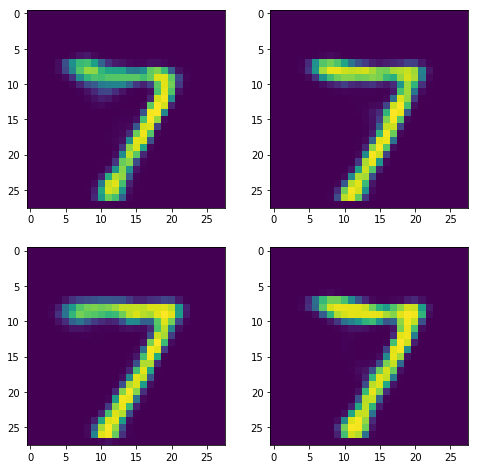

In [92]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = s[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [93]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

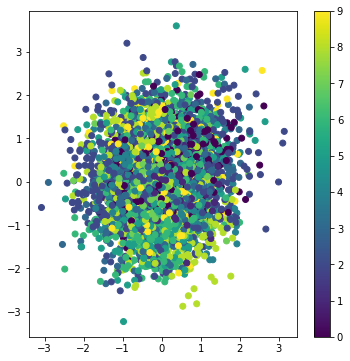

In [94]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test_flat, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()